# Cross-Entropy Method

### 1. Импорт библиотек

In [2]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### 2. Агент

In [3]:
class Agent(nn.Module):
    def __init__(self, env, h_size=32):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size*h_size)+h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size+1)*self.h_size + (self.h_size+1)*self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return

### 3. Инициализация среды

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
    
agent = Agent(env).to(device)

observation space: Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)


### 4. Обучение агента

In [8]:
def cem(n_iterations=100, max_t=1000, gamma=1.0, print_every=1, pop_size=50, elite_frac=0.2, sigma=0.5):
    
    # the number of elite examples is fraction of the population size
    n_elite=int(pop_size*elite_frac)
    # scores is initialized as an empty list
    scores = []
    best_scores = []
    # best_weight is initialized as a random array multiplied by sigma
    # the array dimensions are those of the agent NN weights array 
    best_weight = sigma*np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        # weights_pop is a collection of arrays 
        # an element of this collection is obtained adding a random array to best_weight array for each i 
        weights_pop = [best_weight + (sigma*np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        # Episodes returns when agent uses weights from weights_pop
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])

        # elite rewards indices
        elite_idxs = rewards.argsort()[-n_elite:]
        # pick elite weights arrays using elite indices
        elite_weights = [weights_pop[i] for i in elite_idxs]
        # best_weight is the mean (evaluated by columns) of elite weights
        best_weight = np.array(elite_weights).mean(axis=0)

        # reward after updating best_weight
        best_reward = agent.evaluate(best_weight, gamma=1.0)
        mean_reward = np.mean(rewards)
        # append reward to scores
        scores.append(mean_reward)
        best_scores.append(best_reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tBest score: {:.2f}\tMean score: {:.2f}'.format(i_iteration, best_reward, mean_reward))
    return scores, best_scores

scores, best_scores = cem()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Best score: -27.47	Mean score: -53.84
Episode 2	Best score: -13.42	Mean score: -63.75
Episode 3	Best score: -0.11	Mean score: -60.10
Episode 4	Best score: -37.69	Mean score: -59.92
Episode 5	Best score: -21.86	Mean score: -56.57
Episode 6	Best score: -16.54	Mean score: -55.81
Episode 7	Best score: -32.40	Mean score: -68.27
Episode 8	Best score: -36.39	Mean score: -59.06
Episode 9	Best score: -0.32	Mean score: -56.61
Episode 10	Best score: -2.73	Mean score: -63.02
Episode 11	Best score: -23.82	Mean score: -54.43
Episode 12	Best score: -6.20	Mean score: -57.94
Episode 13	Best score: -11.80	Mean score: -52.53
Episode 14	Best score: -6.13	Mean score: -58.53
Episode 15	Best score: -9.86	Mean score: -55.22
Episode 16	Best score: -19.59	Mean score: -60.48
Episode 17	Best score: -17.70	Mean score: -61.21
Episode 18	Best score: -19.88	Mean score: -61.07
Episode 19	Best score: -45.80	Mean score: -48.43
Episode 20	Best score: -18.81	Mean score: -59.56
Episode 21	Best score: -37.47	Mean 

### 5. Вывод графиков

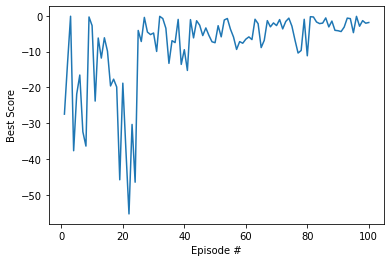

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), best_scores)
plt.ylabel('Best Score')
plt.xlabel('Episode #')
plt.show()